                            OLS Regression Results                            
Dep. Variable:                 UNRATE   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     12.58
Date:                Thu, 16 Jan 2025   Prob (F-statistic):           1.10e-06
Time:                        21:52:16   Log-Likelihood:                -152.55
No. Observations:                  75   AIC:                             313.1
Df Residuals:                      71   BIC:                             322.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               13.3984 

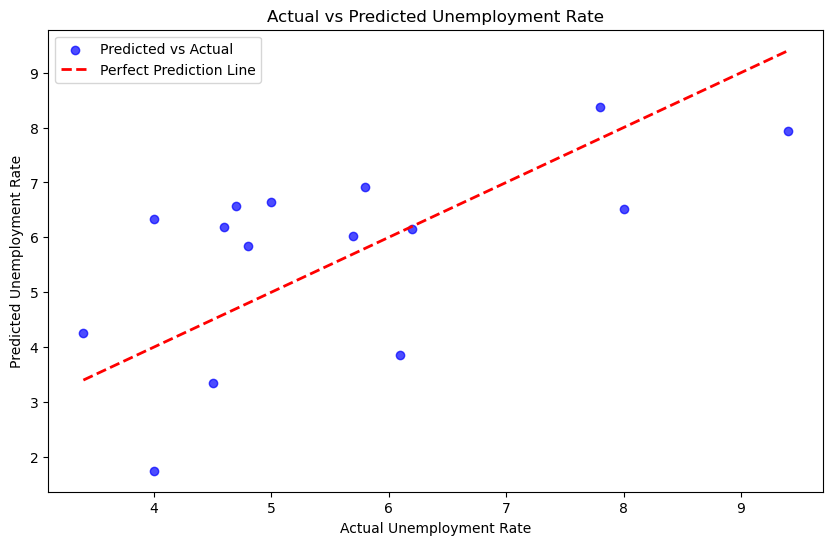

In [53]:
import pandas as pd
import statsmodels.formula.api as smf

# Load the datasets
gdp_data = pd.read_csv('../Data/GDP.csv')
unemployment_data = pd.read_csv('../Data/UNRATE.csv')
fiscal_data = pd.read_csv('../Data/Cleaned_Fiscal.csv')

# Convert date columns to datetime
gdp_data['observation_date'] = pd.to_datetime(gdp_data['observation_date'])
unemployment_data['observation_date'] = pd.to_datetime(unemployment_data['observation_date'])
fiscal_data['Date'] = pd.to_datetime(fiscal_data['Date'])

# Rename columns for consistency
gdp_data.rename(columns={'observation_date': 'Date'}, inplace=True)
unemployment_data.rename(columns={'observation_date': 'Date'}, inplace=True)

# Merge datasets on Date
merged_data = pd.merge(gdp_data, unemployment_data, on='Date', how='inner')
merged_data = pd.merge(merged_data, fiscal_data[['Date', 'Total Taxes']], on='Date', how='inner')

# Drop rows with missing values
merged_data.dropna(inplace=True)

# Build the regression model formula
# Including GDP, Total Taxes, and their interaction term
formula = 'UNRATE ~ GDP * Q("Total Taxes")'

# Fit the model
model = smf.ols(formula=formula, data=merged_data)
results = model.fit()

# Print the model summary
print(results.summary())

# Visualize the residuals
import matplotlib.pyplot as plt

# Visualize Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction Line')
plt.xlabel('Actual Unemployment Rate')
plt.ylabel('Predicted Unemployment Rate')
plt.title('Actual vs Predicted Unemployment Rate')
plt.legend()
plt.show()


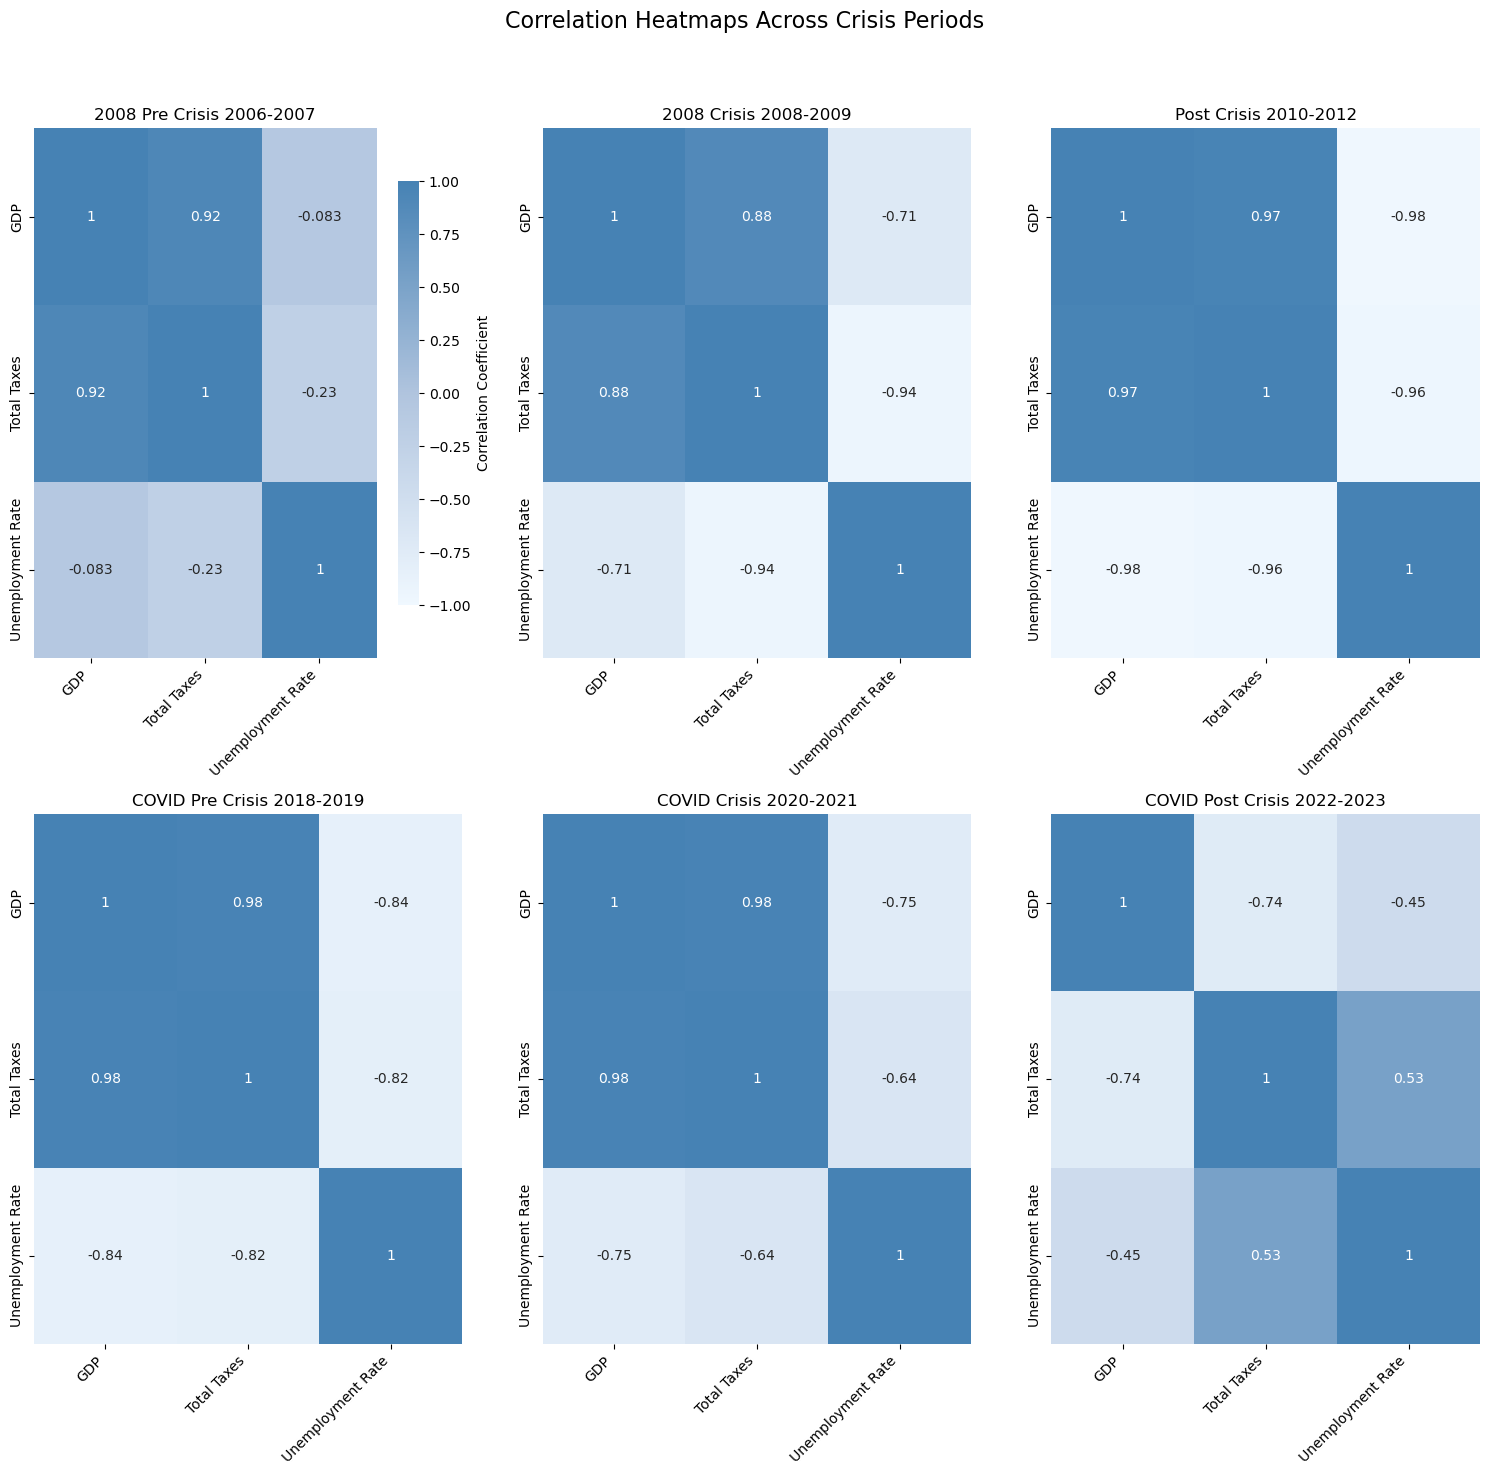

In [49]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap

# Custom colormap: Alice Blue to Light Steel Blue to Steel Blue
soft_blue_cmap = LinearSegmentedColormap.from_list("SoftBlues", ["#f0f8ff", "#b0c4de", "#4682B4"])

# Load the datasets
gdp_data = pd.read_csv('../Data/GDP.csv')
fiscal_data = pd.read_csv('../Data/Cleaned_Fiscal.csv')
unemployment_data = pd.read_csv('../Data/UNRATE.csv')

# Convert date columns to datetime for merging
gdp_data['observation_date'] = pd.to_datetime(gdp_data['observation_date'])
fiscal_data['Date'] = pd.to_datetime(fiscal_data['Date'])
unemployment_data['observation_date'] = pd.to_datetime(unemployment_data['observation_date'])

# Rename columns for consistency
unemployment_data.rename(columns={'observation_date': 'Date'}, inplace=True)
gdp_data.rename(columns={'observation_date': 'Date'}, inplace=True)

# Merge datasets on Date
merged_data = pd.merge(gdp_data, unemployment_data, on='Date', how='inner')
merged_data = pd.merge(merged_data, fiscal_data[['Date', 'Total Taxes']], on='Date', how='inner')

# Rename 'UNRATE' to 'Unemployment Rate' for better labeling
merged_data.rename(columns={'UNRATE': 'Unemployment Rate'}, inplace=True)

# Define periods for correlation analysis
periods = {
    "2008_Pre_Crisis 2006-2007": ('2006-01-01', '2007-12-31'),
    "2008_Crisis 2008-2009": ('2008-01-01', '2009-12-31'),
    "Post_Crisis 2010-2012": ('2010-01-01', '2012-12-31'),
    "COVID_Pre_Crisis 2018-2019": ('2018-01-01', '2019-12-31'),
    "COVID_Crisis 2020-2021": ('2020-01-01', '2021-12-31'),
    "COVID_Post_Crisis 2022-2023": ('2022-01-01', '2023-12-31'),
}

# Calculate correlation matrices for each period
correlation_matrices = {}
for period, (start_date, end_date) in periods.items():
    period_data = merged_data[
        (merged_data['Date'] >= datetime.strptime(start_date, '%Y-%m-%d')) &
        (merged_data['Date'] <= datetime.strptime(end_date, '%Y-%m-%d'))
    ]
    correlation_matrices[period] = period_data[['GDP', 'Total Taxes', 'Unemployment Rate']].corr()

# Plotting heatmaps with Seaborn and enhanced color pattern
fig = plt.figure(figsize=(15, 15))
fig.suptitle('Correlation Heatmaps Across Crisis Periods', fontsize=16)
gs = gridspec.GridSpec(2, 3, figure=fig)

# Create subplots and rotate all x-axis labels 45 degrees
for i, (period, corr_matrix) in enumerate(correlation_matrices.items()):
    ax = fig.add_subplot(gs[i // 3, i % 3])
    sns.heatmap(
        corr_matrix, annot=True, cmap=soft_blue_cmap, vmin=-1, vmax=1, ax=ax,
        cbar=i == 0, cbar_kws={'shrink': 0.8, 'label': 'Correlation Coefficient'}
    )
    ax.set_title(period.replace("_", " "))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')  # Rotate x-axis labels

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
plt.show()
